# Clustering K-means com TensorFlow

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn import datasets
from scipy.spatial import cKDTree
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
from tensorflow.python.framework import ops
ops.reset_default_graph()

In [2]:
# Essa linha de código desabilita o Eager Execution e permite a inicialização de variáveis na sessão, recurso do TF 1.x
tf.compat.v1.disable_eager_execution()

In [3]:
# Sessão
sess = tf.compat.v1.Session()

In [4]:
# Carregando o dataset
iris = datasets.load_iris()

In [14]:
# Definindo os pontos de dados
num_pts, num_feats = iris.data.shape

print('num_pts: {}. num_feats: {}'.format(num_pts, num_feats))

num_pts: 150. num_feats: 4


In [16]:
# Definindo os parâmetros do algoritmo K-means
# Existem 3 tipos de flores no dataset e como já temos esta informação, definimos o k = 3
k = 3 
generations = 25

In [17]:
# Variáveis (serão carregadas quando executarmos a sessão)
data_points = tf.Variable(iris.data)
cluster_labels = tf.Variable(tf.zeros([num_pts], dtype = tf.int64))

In [18]:
# Randomicamente escolhendo os pontos de dados e os centróides
rand_starts = np.array([iris.data[np.random.choice(len(iris.data))] for _ in range(k)])
centroids = tf.Variable(rand_starts)

In [23]:
# Agora precisamos calcular as distâncias entre cada um dos pontos de dados e cada um dos centróides. 
# Fazemos isso expandindo os centróides em uma matriz e o mesmo para os pontos de dados. 
# Vamos então calcular as distâncias euclidianas entre as duas matrizes.
centroid_matrix = tf.reshape(tf.tile(centroids, [num_pts, 1]), [num_pts, k, num_feats])

In [24]:
# Então nós remodelamos os pontos de dados em k (3) repetições
point_matrix = tf.reshape(tf.tile(data_points, [1, k]), [num_pts, k, num_feats])
distances = tf.reduce_sum(input_tensor = tf.square(point_matrix - centroid_matrix), axis = 2)


In [25]:
# A atribuição do centróide é então o centróide mais próximo (menor distância) para cada ponto de dados.
centroid_group = tf.argmin(input=distances, axis=1)

In [26]:
# Encontrar a média (means) do grupo para obter o novo centróide
def data_group_avg(group_ids, data):
    # Soma cada grupo
    sum_total = tf.math.unsorted_segment_sum(data, group_ids, 3)
    # Conta cada grupo
    num_total = tf.math.unsorted_segment_sum(tf.ones_like(data), group_ids, 3)
    # Calcula a média
    avg_by_group = sum_total/num_total
    return(avg_by_group)

In [27]:
# Média
means = data_group_avg(centroid_group, data_points)

In [28]:
# Atualiza os centóides
update = tf.group(centroids.assign(means), cluster_labels.assign(centroid_group))

In [29]:
# Inicializa as variáveis
init = tf.compat.v1.global_variables_initializer()

# Executa a sessãos
sess.run(init)

# Cria o modelo
for i in range(generations):
    _, centroid_group_count = sess.run([update, centroid_group])
    group_count = []
    for ix in range(k):
        group_count.append(np.sum(centroid_group_count==ix))

In [30]:
[centers, assignments] = sess.run([centroids, cluster_labels])

In [31]:
# Encontre quais atribuições de grupo correspondem a quais rótulos de grupo
# Primeiro, precisamos de uma função para encontrar o elemento mais comum
def most_common(my_list):
    return(max(set(my_list), key = my_list.count))

label0 = most_common(list(assignments[0:50]))
label1 = most_common(list(assignments[50:100]))
label2 = most_common(list(assignments[100:150]))

group0_count = np.sum(assignments[0:50]==label0)
group1_count = np.sum(assignments[50:100]==label1)
group2_count = np.sum(assignments[100:150]==label2)

In [32]:
accuracy = (group0_count + group1_count + group2_count)/150.

print('Acurácia: {:.2}'.format(accuracy))

Acurácia: 0.89


In [33]:

# Visualização do Modelo

# Para visualizar nossos agrupamentos e se de fato separaram as espécies de íris, transformaremos as quatro dimensões em duas dimensões usando PCA 
# e traçaremos os pontos e grupos de dados. Após a decomposição do PCA, criamos previsões em uma grade de valores x-y para traçar um gráfico de cores.
pca_model = PCA(n_components = 2)
reduced_data = pca_model.fit_transform(iris.data)

# Transformar centros
reduced_centers = pca_model.transform(centers)

# Step size do mesh plotting
h = .02

# Traçar o limite de decisão. Para isso, atribuiremos uma cor a cada k.
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obter k-means classificações para os pontos de grade
xx_pt = list(xx.ravel())
yy_pt = list(yy.ravel())
xy_pts = np.array([[x,y] for x,y in zip(xx_pt, yy_pt)])
mytree = cKDTree(reduced_centers)
dist, indexes = mytree.query(xy_pts)

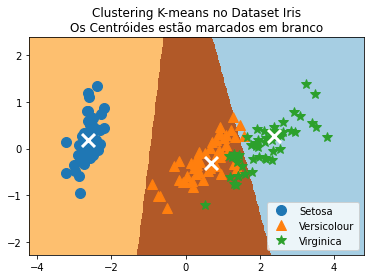

In [34]:
# Coloque o resultado em um gráfico de cores
indexes = indexes.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(indexes, interpolation = 'nearest', extent = (xx.min(), xx.max(), yy.min(), yy.max()), cmap = plt.cm.Paired, aspect = 'auto', origin = 'lower')


# Traçar cada um dos grupos de dados da íris verdadeira
symbols = ['o', '^', '*']
label_name = ['Setosa', 'Versicolour', 'Virginica']
for i in range(3):
    temp_group = reduced_data[(i*50):(50)*(i+1)]
    plt.plot(temp_group[:, 0], temp_group[:, 1], symbols[i], markersize = 10, label = label_name[i])

# Traçar os centróides como um X branco
plt.scatter(reduced_centers[:, 0], reduced_centers[:, 1], marker = 'x', s = 169, linewidths = 3, color = 'w', zorder = 10)
plt.title('Clustering K-means no Dataset Iris\n'
          'Os Centróides estão marcados em branco')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.legend(loc = 'lower right')
plt.show()